In [46]:
import functools
import json

import pandas as pd
import matplotlib.pyplot as plt

from videoannotator import config as cfg, data, io

In [2]:
# label to label group mapping
l2g = {l: g for g, ls in cfg.LABEL_GROUPS.items() for l in ls}

In [59]:
!du -h /root/data/videoannotator/

5.0M	/root/data/videoannotator/agg
23M	/root/data/videoannotator/ave/validation
134M	/root/data/videoannotator/ave
17M	/root/data/videoannotator/checkpoints
11M	/root/data/videoannotator/cmp
1.2G	/root/data/videoannotator/


In [58]:
!ls -lh /root/data/videoannotator/

total 1.1G
drwxr-xr-x 2 root root    0 May 31  2023 agg
drwxr-xr-x 3 root root    0 May 11  2023 ave
drwxr-xr-x 2 root root    0 May 10  2023 checkpoints
drwxr-xr-x 2 root root    0 Jun  7  2023 cmp
-rw-r--r-- 1 root root 985M May 12  2023 embeddings.h5
-rw-r--r-- 1 root root  11K May 31  2023 queries.json
-rw-r--r-- 1 root root  66M May 10  2023 shot-data.csv
-rw-r--r-- 1 root root 647K May 19  2023 text-embeddings.json


## list of all shots

In [38]:
df_shots = pd.read_csv(io.PATHS_STATIC.shot_data)
len(df_shots)

504030

In [4]:
df_shots.head()

,key,yt_id,desc,genre,frame_in,frame_out,start,end,fps,cluster_index
0,HnnBvemHrWA|0,HnnBvemHrWA,Frankie and Johnny - He Just Asked Her Out,Comedy,0,82,0.000000,3.420311,23.974427,8
1,gOJJm_cSRds|3987,gOJJm_cSRds,The Wild Bunch - Bank Shootout,Action,3987,4007,166.302203,167.136425,23.974427,6
2,mDViU8OSRkA|2222,mDViU8OSRkA,Non-Stop - How's Your Daughter? Scene,NaN,2222,2284,92.675917,95.261833,23.976024,3
3,egB-SG97EcI|805,egB-SG97EcI,Kalifornia - I Think I Gotta Kill You Scene,Crime,805,825,33.575190,34.409357,23.976037,0
4,uGsWYV2bWAc|1013,uGsWYV2bWAc,Kill Bill: Vol. 1 - The Bride vs. Gogo,Action,1013,1041,42.250542,43.418375,23.976024,7


## getting individual annotations for a label
this shows the aggregated annotation per shot

In [22]:
label = 'closeup'
lds = data.get_aggregate_labeled_dataset(label=label)
lds

LabeledDataset(label=closeup, cnt=460, pos_cnt=223, neg_cnt=237, pos_rate=0.48)

In [31]:
# lds.keys_pos contains positive annotations and lds.keys_neg contains the negative ones
# note that "key" specifies a unique shot (see the `key` column in `df_shots`)
# for instance closeup has 223 positive and 237 negative instances
len(lds.keys_pos), len(lds.keys_neg)

(223, 237)

In [32]:
# here's the first 3 positive keys
lds.keys_pos[:3]

['09MjH5hbF5Y|1369', '09MjH5hbF5Y|1722', '0QNpXi4k5eU|3005']

### want the granular view?

In [55]:
label = 'closeup'
path = f'{io.PATHS_STATIC._path_base}/agg/{label}.json'
details = json.load(open(path))
details['primary']  # annotator B is the primary for closeup

'B'

In [57]:
# A and C are secondaries
details['secondaries']

['A', 'C']

In [53]:
len(details['data'])

460

In [54]:
details['data'][:3]

[{'key': 'ddrQKAMzUGI|2015',
  'primary': True,
  'secondaries': {'A': True, 'C': True},
  'agg': True,
  'pos_cnt': 3},
 {'key': 'XhwgtlCns34|867',
  'primary': True,
  'secondaries': {'A': True, 'C': True},
  'agg': True,
  'pos_cnt': 3},
 {'key': 'LxmnOxCk3dM|4393',
  'primary': True,
  'secondaries': {'A': True, 'C': True},
  'agg': True,
  'pos_cnt': 3}]

## labeled data summary stats

In [5]:
def stats(l):
    lds = data.get_aggregate_labeled_dataset(l)
    cmp = data.CompDataset(l)
    rand = cmp.get_ordered_dataset_random().lds
    zs = cmp.get_ordered_dataset_zero_shot().lds
    return dict(
        label=l,
        cnt=len(lds),
        cnt_pos=lds.pos_cnt,
        pos_rate=lds.pos_rate,
        keys=set(lds.keys),
        cnt_zs=len(zs),
        cnt_zs_pos=zs.pos_cnt,
        zs_pos_rate=zs.pos_rate,
        cnt_rand=len(rand),
        cnt_rand_pos=rand.pos_cnt,
        agreement=data.get_labeled_dataset_agreement(label=l),
        keys_unique=set(lds.keys) | set(zs.keys) | set(rand.keys),
        unique_cnt=len(set(lds.keys) | set(zs.keys) | set(rand.keys)),
        group=l2g[l],
    )

In [6]:
df_stats = pd.DataFrame(stats(l) for l in cfg.LABELS)
df_stats.drop(columns=['keys', 'keys_unique'])

WARNING 2024-02-02 22:36:21,851 data.py(64) LabeledDataset(label=timelapse, cnt=1000, pos_cnt=0, neg_cnt=1000, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-02 22:36:21,926 data.py(64) LabeledDataset(label=alcohol, cnt=1000, pos_cnt=0, neg_cnt=1000, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-02 22:36:22,121 data.py(64) LabeledDataset(label=shutter-shot, cnt=1000, pos_cnt=0, neg_cnt=1000, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-02 22:36:22,122 data.py(64) LabeledDataset(label=shutter-shot, cnt=1000, pos_cnt=0, neg_cnt=1000, pos_rate=0.00) has no positive annotations.
WARNING 2024-02-02 22:36:22,180 data.py(64) LabeledDataset(label=jump-scare, cnt=1000, pos_cnt=0, neg_cnt=1000, pos_rate=0.00) has no positive annotations.


,label,cnt,cnt_pos,pos_rate,cnt_zs,cnt_zs_pos,zs_pos_rate,cnt_rand,cnt_rand_pos,agreement,unique_cnt,group
0,happy,1000,287,0.287000,1000,689,0.689,1000,33,0.843000,2927,emotions
1,zoom,1000,66,0.066000,1000,66,0.066,1000,26,0.890000,2929,motion
2,static-shot,1000,451,0.451000,1000,16,0.016,1000,73,0.881000,2995,shot_types
3,low-angle,272,102,0.375000,1000,166,0.166,1000,35,0.852941,2253,shot_types
4,drama,599,203,0.338898,1000,590,0.590,1000,129,0.646077,2563,genres
5,violence,575,193,0.335652,1000,807,0.807,1000,109,0.787826,2546,sensitivities
6,cowboy-shot,1000,373,0.373000,1000,121,0.121,1000,17,0.848000,2934,shot_types
7,sci-fi,768,257,0.334635,1000,777,0.777,1000,21,0.842448,2712,genres
8,day,249,124,0.497992,1000,505,0.505,1000,370,0.975904,2233,time_location
9,intimacy,1000,336,0.336000,1000,473,0.473,1000,15,0.904000,2909,sensitivities


## label group aggregation

In [7]:
df_stats.groupby('group').apply(
    lambda x: pd.Series(dict(
        label_cnt=len(x),
        va_cnt_mean=np.mean(x.cnt),
        unique_cnt_mean=np.mean(x.unique_cnt),
        agreement_pct_mean=np.mean(x.agreement) * 100,
        pos_pct_mean=np.mean(x.pos_rate) * 100,
    ))
).round(1).astype(int)

,label_cnt,va_cnt_mean,unique_cnt_mean,agreement_pct_mean,pos_pct_mean
group,,,,,
emotions,5,1003,2917,75,26
events_actions,4,1000,2925,85,28
focus,3,358,2343,84,46
genres,6,717,2661,82,34
motion,6,1000,2947,90,10
sensitivities,7,939,2817,82,25
shot_types,22,687,2654,83,40
time_location,3,530,2493,89,36


### visualization

In [8]:
def get_row(l):
    ds = data.get_aggregate_labeled_dataset(label=l)
    return dict(
        label=l,
        pos_rate=ds.pos_rate,
        pos_cnt=ds.pos_cnt,
        data_score=ds.data_score,
        cnt=len(ds),
        group=l2g[l],
    )

d = pd.DataFrame(map(get_row, cfg.LABELS)).sort_values(by='pos_cnt')

In [9]:
def make_box_plot(col, name, xlim):
    d.boxplot(col, by='group', vert=False)
    plt.xlim(xlim)
    plt.suptitle('')
    plt.xlabel('')
    _ = plt.title(f'Distribution of of {name} by label group')

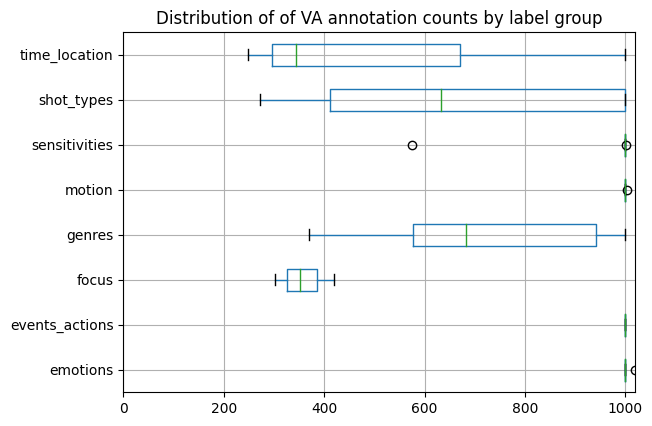

In [10]:
make_box_plot(col='cnt', name='VA annotation counts', xlim=[0, 1_020])

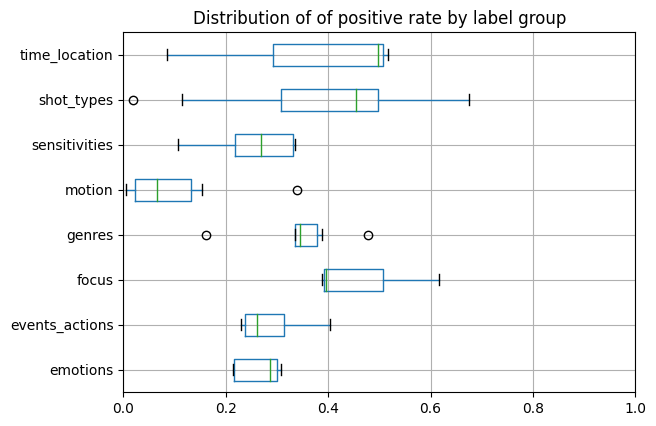

In [11]:
make_box_plot(col='pos_rate', name='positive rate', xlim=[0, 1])

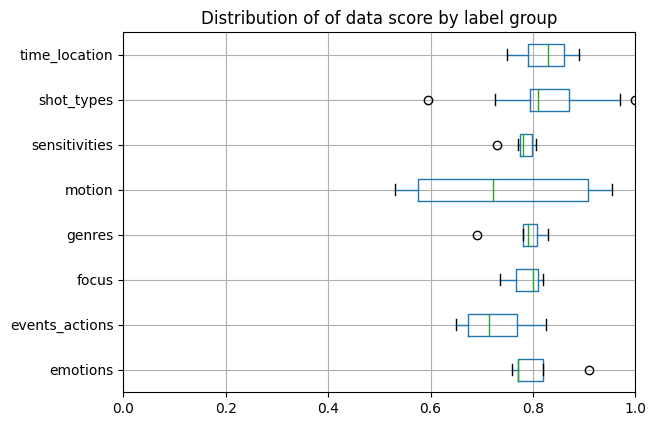

In [12]:
make_box_plot(col='data_score', name='data score', xlim=[0, 1])

## global stats across all labels

In [13]:
# number of unique clips annotated
len(functools.reduce(set.union, df_stats.keys_unique))

70852

In [14]:
# number of VA annotations
df_stats.cnt.sum()

43686

In [15]:
# number of total annotations (VA + zero shot + random)
df_stats.unique_cnt.sum()

152579

In [16]:
# agreement distribution across all labels
df_stats.agreement.describe()

count    56.000000
mean      0.836601
std       0.087457
min       0.624000
25%       0.786370
50%       0.845817
75%       0.889446
max       0.988000
Name: agreement, dtype: float64

In [17]:
# positive rate across all labels
df_stats.pos_rate.describe()

count    56.000000
mean      0.328204
std       0.161572
min       0.005982
25%       0.218500
50%       0.335826
75%       0.458527
max       0.675000
Name: pos_rate, dtype: float64